<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-просмотр-данных" data-toc-modified-id="Загрузка-и-просмотр-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и просмотр данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование-временного-ряда" data-toc-modified-id="Ресемплирование-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование временного ряда</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Декомпозиция-данных,-проверка-на-тренды-и-сезонность" data-toc-modified-id="Декомпозиция-данных,-проверка-на-тренды-и-сезонность-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Декомпозиция данных, проверка на тренды и сезонность</a></span></li></ul></li><li><span><a href="#Создание-и-обучение-моделей" data-toc-modified-id="Создание-и-обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание и обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-моделей,-выбор-лучшей" data-toc-modified-id="Тестирование-моделей,-выбор-лучшей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование моделей, выбор лучшей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

У нас есть исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Задача: постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Этапы работы:

1. Загрузка данных и выполнить их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение нескольких моделей с различными гиперпараметрами (тестовую выборка - 10% от исходных данных).
4. Проверка модели на тестовой выборке.
5. Вывод.


## Загрузка и просмотр данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose


pd.options.mode.chained_assignment = None




In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()
print()
display(data)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Подготовка данных

### Ресемплирование временного ряда

In [3]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
data.info()
print()
display(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB



,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [5]:
print(data.isna().sum())


num_orders    0
dtype: int64


## Анализ данных

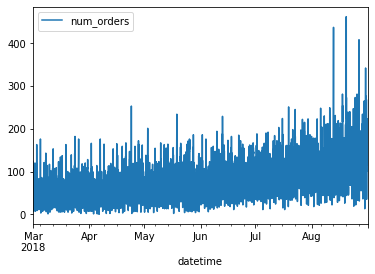

In [6]:
data.plot()
plt.show()


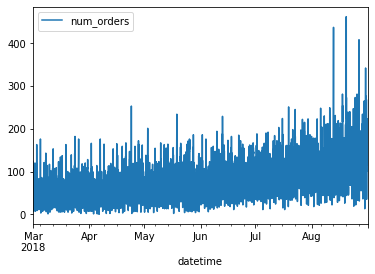

In [7]:
data.resample('1H').sum().plot()
plt.show()

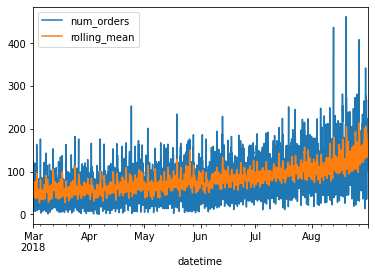

In [8]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()
plt.show()

### Декомпозиция данных, проверка на тренды и сезонность

**Разделение по часу**

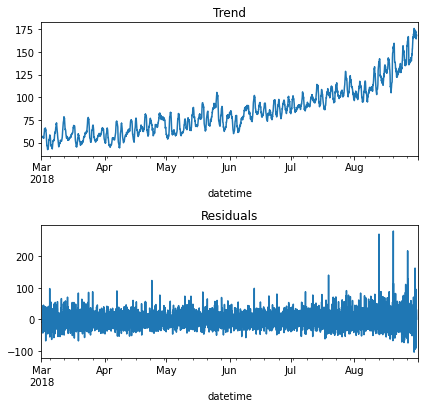

In [9]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


**Разделение по дню**

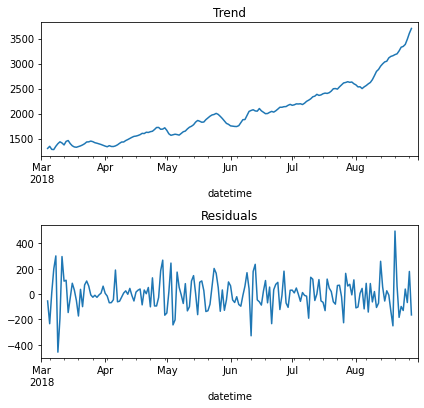

In [10]:
dec = seasonal_decompose(data.resample('1D')['num_orders'].sum())
plt.figure(figsize=(6, 8))
plt.subplot(311)
dec.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
dec.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## Создание и обучение моделей

### Создание признаков

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 30, 24)

In [12]:
data = data.dropna()
display(data)

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,56.208333,4,6,11.0,20.0,64.0,75.0,120.0,90.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 07:00:00,7,56.166667,4,7,11.0,11.0,20.0,64.0,75.0,120.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 08:00:00,46,55.833333,4,8,7.0,11.0,11.0,20.0,64.0,75.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 09:00:00,45,56.333333,4,9,46.0,7.0,11.0,11.0,20.0,64.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 10:00:00,54,55.333333,4,10,45.0,46.0,7.0,11.0,11.0,20.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0
2018-08-31 20:00:00,154,167.541667,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0
2018-08-31 21:00:00,159,168.041667,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0


### Обучение

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [14]:
features = train.drop(['num_orders'], axis=1)
target = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [15]:
features_train, features_valid, target_train, target_valid = train_test_split(
   features, target,  shuffle=False, test_size=0.2)

#### LinearRegression

In [16]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('RMSE модели:', rmse)

RMSE модели: 33.343059759765254


#### RandomForestRegressor

In [26]:
best_result = 1000000
best_est = 0
best_depth = 0

for est in range(15, 25):
    for depth in range (10, 20):
        model1 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model1.fit(features_train, target_train)
        predictions_valid = model1.predict(features_valid)


        rmse = mean_squared_error(target_valid, predictions_valid)**0.5        

        result = rmse
        
        if result < best_result:
            best_model = model1
            best_result = result
            best_est = est
            best_depth = depth
                    
print('Лучшее RMSE:', best_result, 'best_est:', best_est, 'best_depth:', best_depth)

Лучшее RMSE: 32.34018889471275 best_est: 21 best_depth: 13


In [27]:
model1 = RandomForestRegressor(random_state=12345, n_estimators=21, max_depth=13)
model1.fit(features_train, target_train)
predictions_valid = model1.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('RMSE модели:', rmse)

RMSE модели: 32.34018889471275


#### LGBMRegressor

In [19]:
model2 = LGBMRegressor()
model2.fit(features_train, target_train)
predictions_valid = model2.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('RMSE модели:', rmse)

RMSE модели: 32.413530214001725


#### CatBoostRegressor

In [39]:
for depth in range (3, 9):
    model3 = CatBoostRegressor(iterations=100, learning_rate=0.26, depth=depth, verbose=False) 
    model3.fit(features_train, target_train) 
    pred_valid = model3.predict(features_valid) 
    rmse = mean_squared_error(target_valid, pred_valid)**0.5
            
    print('RMSE модели:', rmse, depth)

RMSE модели: 32.097766739339896 3
RMSE модели: 32.25767197698645 4
RMSE модели: 32.650879301824624 5
RMSE модели: 32.614608428464905 6
RMSE модели: 32.94176094821556 7
RMSE модели: 33.25641665288994 8


In [40]:
model3 = CatBoostRegressor(iterations=100, learning_rate=0.26, depth=3, verbose=False) 
model3.fit(features_train, target_train) 
pred_valid = model3.predict(features_valid) 
rmse = mean_squared_error(target_valid, pred_valid)**0.5
            
print('RMSE модели:', rmse)

RMSE модели: 32.097766739339896


## Тестирование моделей, выбор лучшей

LinearRegression

In [41]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE модели:', rmse)

RMSE модели: 46.91945394258307


RandomForestRegressor

In [42]:
predictions_test = model1.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE модели:', rmse)

RMSE модели: 54.43879714814619


LGBMRegressor

In [43]:
predictions_test = model2.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE модели:', rmse)

RMSE модели: 57.82719056798602


CatBoostRegressor

In [44]:
predictions_test = model3.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE модели:', rmse)

RMSE модели: 54.32735086170757


Лучшая модель - LinearRegression: 

RMSE модели: 46.91945394258307


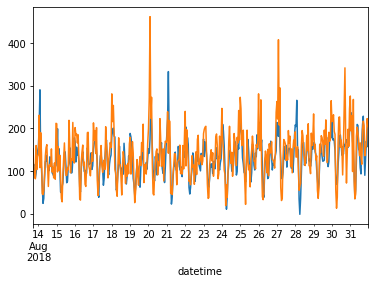

In [45]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE модели:', rmse)
test['predictions_test'] = predictions_test 
test['predictions_test'].plot()
target_test.plot()
plt.show()

## Вывод

Модель для прогноза временного ряда из нашей задачи построена.

Точность предсказания этой модели достаточная для решения нашей задачи (RMSE модели: 46.9).

Вот такие дела.